In [18]:
# This notebook analyses the ouput of 
# running complexity.py

# ! grep 'for_parser:' val_csv_all_models_all_cities/complexity_results_all_cities_io_pred_horiz_combo_results_thin_margin.txt | sed "s/for_parser:,//g" > val_csv_all_models_all_cities/PM_all_cities_io_pred_combo.csv
# ! grep 'for_parser:' complexity_results_all_cities_io_4_wide_margin_default_plus_minus_final.txt | sed "s/for_parser:,//g" > PM_complexity_results_all_cities_io_4_standard_wide_margins.csv
# ! grep 'for_parser:' complexity_results_all_cities_io_4_wide_margin_default_plus_minus_final_london.txt | sed "s/for_parser:,//g" > PM_complexity_results_all_cities_io_4_standard_wide_margins_london.csv
# ! grep 'for_parser:' complexity_results_all_cities_io_4_wide_margin_default_plus_minus_final_with_latest_metrics_run_1.txt | sed "s/for_parser:,//g" > PM_complexity_results_all_cities_io_4_standard_wide_margins_run_1.csv

In [1]:
! grep 'for_parser:' complexity_run_15jun/complexity_run_1.txt | sed "s/for_parser:,//g" >> PM_complexity_results_all_cities_jun_10.csv
! grep 'for_parser:' complexity_run_15jun/complexity_run_2.txt | sed "s/for_parser:,//g" >> PM_complexity_results_all_cities_jun_10.csv
! grep 'for_parser:' complexity_run_15jun/complexity_run_3.txt | sed "s/for_parser:,//g" >> PM_complexity_results_all_cities_jun_10.csv
! grep 'for_parser:' complexity_run_15jun/complexity_run_4.txt | sed "s/for_parser:,//g" >> PM_complexity_results_all_cities_jun_10.csv
! grep 'for_parser:' complexity_run_15jun/complexity_run_5.txt | sed "s/for_parser:,//g" >> PM_complexity_results_all_cities_jun_10.csv
! grep 'for_parser:' complexity_run_15jun/complexity_run_6.txt | sed "s/for_parser:,//g" >> PM_complexity_results_all_cities_jun_10.csv
! grep 'for_parser:' complexity_run_15jun/complexity_run_7.txt | sed "s/for_parser:,//g" >> PM_complexity_results_all_cities_jun_10.csv
! grep 'for_parser:' complexity_run_15jun/complexity_run_8.txt | sed "s/for_parser:,//g" >> PM_complexity_results_all_cities_jun_10.csv
! grep 'for_parser:' complexity_run_15jun/complexity_run_9.txt | sed "s/for_parser:,//g" >> PM_complexity_results_all_cities_jun_10.csv
! grep 'for_parser:' complexity_run_15jun/complexity_run_10.txt | sed "s/for_parser:,//g" >> PM_complexity_results_all_cities_jun_10.csv

grep: complexity_run_15jun/complexity_run_7.txt: No such file or directory


In [2]:
import sys
import os

sys.path.append("../")
# ! pip install -r ../../../requirements.txt
import config

import numpy as np
import matplotlib.pyplot as plt
from smartprint import smartprint as sprint
from preprocessing.ProcessRaw import ProcessRaw
import pandas as pd

In [3]:
city_color = {"london" : "#E69F00", 
             "melbourne": "#0072B2",
             "madrid": "#CC79A7"}

GIGO case:  madrid-4-1-45-
GIGO case:  madrid-4-1-25-


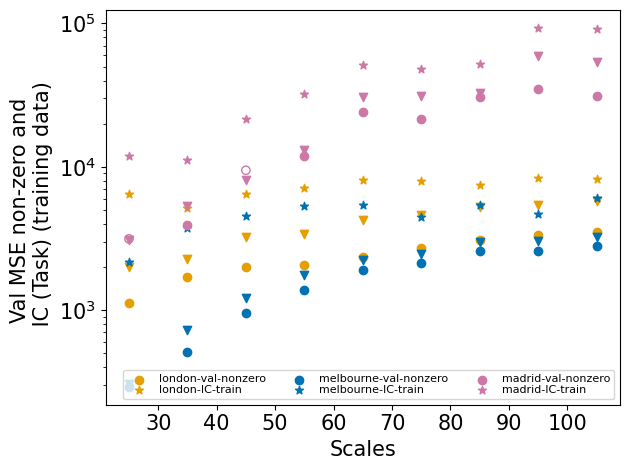

In [56]:
import pandas as pd


# scales
for city in config.city_list:

    cityname = city.lower()

    city_label_printed = []

    val_loss_non_zero_list = []
    csr_model_list = []
    csr_PM_list = []
    csr_PM_frac_list = []
    
    for scale in config.scales[::-1]: #list(range(25, 206, 30))[::-1] + 
        for i_o_length in config.i_o_lengths_def:
            for pred_horiz in config.pred_horiz_def:
                prefix = ProcessRaw.file_prefix(cityname=cityname,
                                                io_length=i_o_length, 
                                                pred_horiz=pred_horiz, 
                                                scale=scale)
                filename = "val_csv_" + prefix + ".csv"
                try:
                    df = pd.read_csv(os.path.join("val_csv_all_models_all_cities", filename))
                except (pd.errors.EmptyDataError, FileNotFoundError) as e:
                    print (cityname, " Empty/Not found, ignoring; plot will be missing")
                    print (e)
                    continue
                    
                    
                epoch_list = df.epoch.tolist()
                val_loss = df.val_loss.tolist()
                naive_model= df["naive-model-non-zero"].tolist()
                val_non_zero_mse = df["val_non_zero_mse"].tolist()

                min_val_mse = 999999999999999
                min_val_mse_non_zero = 999999999999999
                for early_stopping in range(1, min(7, len(val_loss))):  # if there were less than 7 epochs (later early stopping changed to 3; that's why)
                    min_val_mse = min (min_val_mse, val_loss[-early_stopping])
                    min_val_mse_non_zero = min (min_val_mse_non_zero, val_non_zero_mse[-early_stopping])

                alpha = 1
                facecolor = city_color[cityname]
                
                if naive_model[-1] < min_val_mse_non_zero:
                    # invalid, GIGO regime
                    print ("GIGO case: ", prefix)                    
                    
                    facecolor='none'
                    
                    # continue                    
                    
                if cityname in city_label_printed:
                    plt.scatter(scale, min_val_mse_non_zero, 
                                alpha=alpha,
                                facecolor=facecolor,
                                edgecolors=city_color[cityname])                 
                else:
                    plt.scatter(scale, min_val_mse_non_zero, 
                                alpha=alpha, 
                                label=cityname+ "-val-nonzero",
                                facecolor=facecolor,
                                edgecolors=city_color[cityname])
                    city_label_printed.append(cityname)
                plt.scatter(scale, naive_model[-1], marker='v', color=city_color[cityname])

    for CSR_type in [
    'CSR_PM_sum_y_exceeding_r_x_max',
        ]:

        cityname = city.lower()

        city_label_printed = []      
        # df = pd.read_csv("PM_complexity_results_all_cities_io_4_standard_wide_margins_run_1.csv")        
        df = pd.read_csv("PM_complexity_results_all_cities_jun_10.csv")        


        for scale in config.scales[::-1]:
            for i_o_length in config.i_o_lengths_def:
                for pred_horiz in config.pred_horiz_def:
                    filtered_rows = df[    \
                                       (df["i_o_length"]==i_o_length) & \
                                       (df["grid_size"]==scale) & \
                                       (df["prediction_horizon"]==pred_horiz) &\
                                       (df["cityname"]==cityname)
                                      ]
                    if filtered_rows.shape[0] == 1:
                        range_ = [0]
                    else:
                        range_ = list(range(filtered_rows.shape[0]))
                        # sprint (cityname, scale, i_o_length, pred_horiz, filtered_rows.shape)
                        # no worries, will be plotted multiple times # this is three times because of first combination overlap

                    # if printing only one star even if multiple present, uncomment below:
                    range_ = [0]
                    
                    a = []
                    for i in range_:
                            a.append(filtered_rows.iloc[i][CSR_type] / 500)  
                            
                    for i in [0]:
                        if cityname in city_label_printed:
                            plt.scatter(scale,  np.mean(a), marker='*',color=city_color[cityname], alpha=1)
                        else:
                            plt.scatter(scale,  np.mean(a), marker='*',label=cityname + "-IC-train", alpha=1, color=city_color[cityname])
                            city_label_printed.append(cityname)                                    

plt.xlabel("Scales", fontsize=15)
plt.ylabel("Val MSE non-zero and \n IC (Task) (training data)", fontsize=15)
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc="lower right", fontsize=8, ncol=3, labelspacing=0.02)
plt.tight_layout()
plt.savefig("Scales_csr_val_combo.png")
plt.show()





GIGO case:  melbourne-1-1-55-
GIGO case:  melbourne-2-1-55-
GIGO case:  madrid-1-1-55-
GIGO case:  madrid-7-1-55-
GIGO case:  madrid-8-1-55-


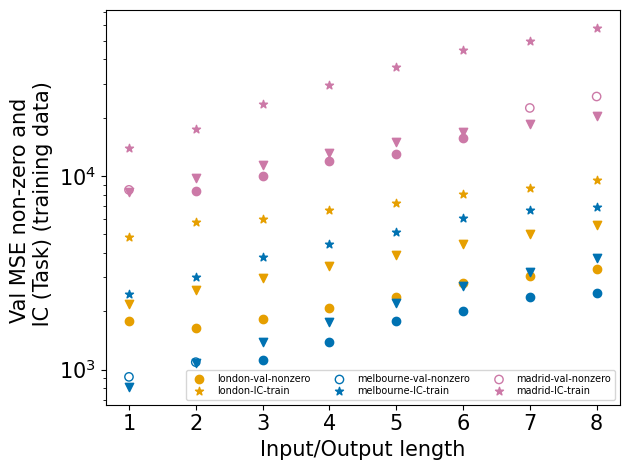

In [57]:
import pandas as pd


# scales
for city in config.city_list:

    cityname = city.lower()

    city_label_printed = []

    val_loss_non_zero_list = []
    csr_model_list = []
    csr_PM_list = []
    csr_PM_frac_list = []
    
    for scale in config.scales_def: #list(range(25, 206, 30))[::-1] + 
        for i_o_length in config.i_o_lengths:
            for pred_horiz in config.pred_horiz_def:
                prefix = ProcessRaw.file_prefix(cityname=cityname,
                                                io_length=i_o_length, 
                                                pred_horiz=pred_horiz, 
                                                scale=scale)
                filename = "val_csv_" + prefix + ".csv"
                try:
                    df = pd.read_csv(os.path.join("val_csv_all_models_all_cities", filename))
                except (pd.errors.EmptyDataError, FileNotFoundError) as e:
                    print (cityname, " Empty/Not found, ignoring; plot will be missing")
                    print (e)
                    continue
                    
                    
                epoch_list = df.epoch.tolist()
                val_loss = df.val_loss.tolist()
                naive_model= df["naive-model-non-zero"].tolist()
                val_non_zero_mse = df["val_non_zero_mse"].tolist()

                min_val_mse = 999999999999999
                min_val_mse_non_zero = 999999999999999
                for early_stopping in range(1, min(7, len(val_loss))):  # if there were less than 7 epochs (later early stopping changed to 3; that's why)
                    min_val_mse = min (min_val_mse, val_loss[-early_stopping])
                    min_val_mse_non_zero = min (min_val_mse_non_zero, val_non_zero_mse[-early_stopping])

                alpha = 1
                facecolor = city_color[cityname]
                
                if naive_model[-1] < min_val_mse_non_zero:
                    # invalid, GIGO regime
                    print ("GIGO case: ", prefix)                    
                    
                    facecolor='none'
                    
                    # continue                    
                    
                if cityname in city_label_printed:
                    plt.scatter(i_o_length, min_val_mse_non_zero, 
                                alpha=alpha,
                                facecolor=facecolor,
                                edgecolors=city_color[cityname])                 
                else:
                    plt.scatter(i_o_length, min_val_mse_non_zero, 
                                alpha=alpha, 
                                label=cityname+ "-val-nonzero",
                                facecolor=facecolor,
                                edgecolors=city_color[cityname])
                    city_label_printed.append(cityname)
                plt.scatter(i_o_length, naive_model[-1], marker='v', color=city_color[cityname])

    for CSR_type in [
    'CSR_PM_sum_y_exceeding_r_x_max',
        ]:

        cityname = city.lower()

        city_label_printed = []
        # df = pd.read_csv("PM_complexity_results_all_cities_io_4_standard_wide_margins_run_1.csv")        
        df = pd.read_csv("PM_complexity_results_all_cities_jun_10.csv")        

        for scale in config.scales_def:
            for i_o_length in config.i_o_lengths:
                for pred_horiz in config.pred_horiz_def:
                    filtered_rows = df[    \
                                       (df["i_o_length"]==i_o_length) & \
                                       (df["grid_size"]==scale) & \
                                       (df["prediction_horizon"]==pred_horiz) &\
                                       (df["cityname"]==cityname)
                                      ]
                    if filtered_rows.shape[0] == 1:
                        range_ = [0]
                    else:
                        range_ = list(range(filtered_rows.shape[0]))
                        # sprint (cityname, scale, i_o_length, pred_horiz, filtered_rows.shape)
                        # no worries, will be plotted multiple times # this is three times because of first combination overlap

                    # if printing only one star even if multiple present, uncomment below:
                    # range_ = [0]
                    
                    a = []
                    for i in range_:
                            a.append(filtered_rows.iloc[i][CSR_type] / 500)  
                            
                    for i in [0]:
                        if cityname in city_label_printed:
                            plt.scatter(i_o_length,  np.mean(a), marker='*',color=city_color[cityname], alpha=1)
                        else:
                            plt.scatter(i_o_length,  np.mean(a), marker='*',label=cityname + "-IC-train", alpha=1, color=city_color[cityname])
                            city_label_printed.append(cityname)                                    
                  

plt.xlabel("Input/Output length", fontsize=15)
plt.ylabel("Val MSE non-zero and \n IC (Task) (training data)", fontsize=15)
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc="lower right", fontsize=7, ncol=3, labelspacing=0.2)
plt.tight_layout()
plt.savefig("i_o_length_csr_val_combo.png")
plt.show()





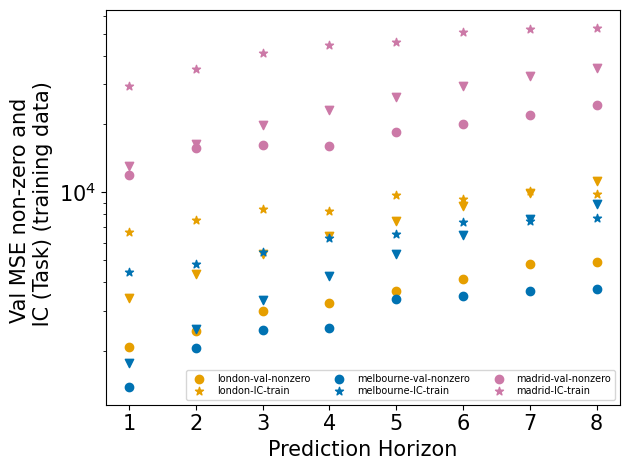

In [59]:
import pandas as pd

# scales
for city in config.city_list:

    cityname = city.lower()

    city_label_printed = []

    val_loss_non_zero_list = []
    csr_model_list = []
    csr_PM_list = []
    csr_PM_frac_list = []
    
    for scale in config.scales_def: #list(range(25, 206, 30))[::-1] + 
        for i_o_length in config.i_o_lengths_def:
            for pred_horiz in config.pred_horiz:
                prefix = ProcessRaw.file_prefix(cityname=cityname,
                                                io_length=i_o_length, 
                                                pred_horiz=pred_horiz, 
                                                scale=scale)
                filename = "val_csv_" + prefix + ".csv"
                try:
                    df = pd.read_csv(os.path.join("val_csv_all_models_all_cities", filename))
                except (pd.errors.EmptyDataError, FileNotFoundError) as e:
                    print (cityname, " Empty/Not found, ignoring; plot will be missing")
                    print (e)
                    continue
                    
                    
                epoch_list = df.epoch.tolist()
                val_loss = df.val_loss.tolist()
                naive_model= df["naive-model-non-zero"].tolist()
                val_non_zero_mse = df["val_non_zero_mse"].tolist()

                min_val_mse = 999999999999999
                min_val_mse_non_zero = 999999999999999
                for early_stopping in range(1, min(7, len(val_loss))):  # if there were less than 7 epochs (later early stopping changed to 3; that's why)
                    min_val_mse = min (min_val_mse, val_loss[-early_stopping])
                    min_val_mse_non_zero = min (min_val_mse_non_zero, val_non_zero_mse[-early_stopping])

                alpha = 1
                facecolor = city_color[cityname]
                
                if naive_model[-1] < min_val_mse_non_zero:
                    # invalid, GIGO regime
                    print ("GIGO case: ", prefix)                    
                    
                    facecolor='none'
                    
                    # continue                    
                    
                if cityname in city_label_printed:
                    plt.scatter(pred_horiz, min_val_mse_non_zero, 
                                alpha=alpha,
                                facecolor=facecolor,
                                edgecolors=city_color[cityname])                 
                else:
                    plt.scatter(pred_horiz, min_val_mse_non_zero, 
                                alpha=alpha, 
                                label=cityname+ "-val-nonzero",
                                facecolor=facecolor,
                                edgecolors=city_color[cityname])
                    city_label_printed.append(cityname)
                plt.scatter(pred_horiz, naive_model[-1], marker='v', color=city_color[cityname])

    for CSR_type in [
    'CSR_PM_sum_y_exceeding_r_x_max',
        ]:

        cityname = city.lower()

        city_label_printed = []
        # df = pd.read_csv("PM_complexity_results_all_cities_io_4_standard_wide_margins_run_1.csv")        
        df = pd.read_csv("PM_complexity_results_all_cities_jun_10.csv")                


        for scale in config.scales_def:
            for i_o_length in config.i_o_lengths_def:
                for pred_horiz in config.pred_horiz:
                    filtered_rows = df[    \
                                       (df["i_o_length"]==i_o_length) & \
                                       (df["grid_size"]==scale) & \
                                       (df["prediction_horizon"]==pred_horiz) &\
                                       (df["cityname"]==cityname)
                                      ]
                    if filtered_rows.shape[0] == 1:
                        range_ = [0]
                    else:
                        range_ = list(range(filtered_rows.shape[0]))
                        # sprint (cityname, scale, i_o_length, pred_horiz, filtered_rows.shape)
                        # no worries, will be plotted multiple times # this is three times because of first combination overlap

                    # if printing only one star even if multiple present, uncomment below:
                    # range_ = [0]
                    
                    
                    a = []
                    for i in range_:
                            a.append(filtered_rows.iloc[i][CSR_type] / 500)  
                            
                    for i in [0]:
                        if cityname in city_label_printed:
                            plt.scatter(pred_horiz,  np.mean(a), marker='*',color=city_color[cityname], alpha=1)
                        else:
                            plt.scatter(pred_horiz,  np.mean(a), marker='*',label=cityname + "-IC-train", alpha=1, color=city_color[cityname])
                            city_label_printed.append(cityname)                                    
                  

plt.xlabel("Prediction Horizon", fontsize=15)
plt.ylabel("Val MSE non-zero and \n IC (Task) (training data)", fontsize=15)
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc="lower right", fontsize=7, ncol=3, labelspacing=0.2)
plt.tight_layout()
plt.savefig("pred_horiz_csr_val_combo.png")
plt.show()





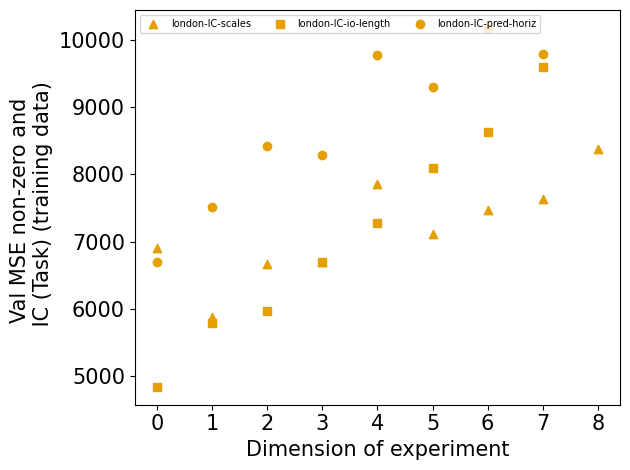

In [14]:
# ALL COMBINED
import pandas as pd

# scales
for city in config.city_list_def:

    cityname = city.lower()

    city_label_printed = []

    val_loss_non_zero_list = []
    csr_model_list = []
    csr_PM_list = []
    csr_PM_frac_list = []
    

    for CSR_type in [
    'CSR_PM_sum_y_exceeding_r_x_max',
        ]:

        cityname = city.lower()

        city_label_printed = []
        # df = pd.read_csv("PM_complexity_results_all_cities_io_4_standard_wide_margins_run_1.csv")        
        df = pd.read_csv("PM_complexity_results_all_cities_jun_10.csv")                


        for counter, scale in enumerate(config.scales):
            for i_o_length in config.i_o_lengths_def:
                for pred_horiz in config.pred_horiz_def:
                    filtered_rows = df[    \
                                       (df["i_o_length"]==i_o_length) & \
                                       (df["grid_size"]==scale) & \
                                       (df["prediction_horizon"]==pred_horiz) &\
                                       (df["cityname"]==cityname)
                                      ]
                    if filtered_rows.shape[0] == 1:
                        range_ = [0]
                    else:
                        range_ = list(range(filtered_rows.shape[0]))
                        # sprint (cityname, scale, i_o_length, pred_horiz, filtered_rows.shape)
                        # no worries, will be plotted multiple times # this is three times because of first combination overlap

                    # if printing only one star even if multiple present, uncomment below:
                    # range_ = [0]
                    
                    
                    a = []
                    for i in range_:
                            a.append(filtered_rows.iloc[i][CSR_type] / 500)  
                            
                    for i in [0]:
                        if cityname in city_label_printed:
                            plt.scatter(counter,  np.mean(a), marker='^',color=city_color[cityname], alpha=1)
                        else:
                            plt.scatter(counter,  np.mean(a), marker='^',label=cityname + "-IC-scales", alpha=1, color=city_color[cityname])
                            city_label_printed.append(cityname)                                    
                  
    for CSR_type in [
    'CSR_PM_sum_y_exceeding_r_x_max',
        ]:

        cityname = city.lower()

        city_label_printed = []
        # df = pd.read_csv("PM_complexity_results_all_cities_io_4_standard_wide_margins_run_1.csv")        
        df = pd.read_csv("PM_complexity_results_all_cities_jun_10.csv")                


        for scale in config.scales_def:
            for counter, i_o_length in enumerate(config.i_o_lengths):
                for pred_horiz in config.pred_horiz_def:
                    filtered_rows = df[    \
                                       (df["i_o_length"]==i_o_length) & \
                                       (df["grid_size"]==scale) & \
                                       (df["prediction_horizon"]==pred_horiz) &\
                                       (df["cityname"]==cityname)
                                      ]
                    if filtered_rows.shape[0] == 1:
                        range_ = [0]
                    else:
                        range_ = list(range(filtered_rows.shape[0]))
                        # sprint (cityname, scale, i_o_length, pred_horiz, filtered_rows.shape)
                        # no worries, will be plotted multiple times # this is three times because of first combination overlap

                    # if printing only one star even if multiple present, uncomment below:
                    # range_ = [0]
                    
                    
                    a = []
                    for i in range_:
                            a.append(filtered_rows.iloc[i][CSR_type] / 500)  
                            
                    for i in [0]:
                        if cityname in city_label_printed:
                            plt.scatter(counter,  np.mean(a), marker='s',color=city_color[cityname], alpha=1)
                        else:
                            plt.scatter(counter,  np.mean(a), marker='s',label=cityname + "-IC-io-length", alpha=1, color=city_color[cityname])
                            city_label_printed.append(cityname)                                    
    for CSR_type in [
    'CSR_PM_sum_y_exceeding_r_x_max',
        ]:

        cityname = city.lower()

        city_label_printed = []
        # df = pd.read_csv("PM_complexity_results_all_cities_io_4_standard_wide_margins_run_1.csv")        
        df = pd.read_csv("PM_complexity_results_all_cities_jun_10.csv")                


        for scale in config.scales_def:
            for i_o_length in config.i_o_lengths_def:
                for counter, pred_horiz in enumerate(config.pred_horiz):
                    filtered_rows = df[    \
                                       (df["i_o_length"]==i_o_length) & \
                                       (df["grid_size"]==scale) & \
                                       (df["prediction_horizon"]==pred_horiz) &\
                                       (df["cityname"]==cityname)
                                      ]
                    if filtered_rows.shape[0] == 1:
                        range_ = [0]
                    else:
                        range_ = list(range(filtered_rows.shape[0]))
                        # sprint (cityname, scale, i_o_length, pred_horiz, filtered_rows.shape)
                        # no worries, will be plotted multiple times # this is three times because of first combination overlap

                    # if printing only one star even if multiple present, uncomment below:
                    # range_ = [0]
                    
                    
                    a = []
                    for i in range_:
                            a.append(filtered_rows.iloc[i][CSR_type] / 500)  
                            
                    for i in [0]:
                        if cityname in city_label_printed:
                            plt.scatter(counter,  np.mean(a), marker='o',color=city_color[cityname], alpha=1)
                        else:
                            plt.scatter(counter,  np.mean(a), marker='o',label=cityname + "-IC-pred-horiz", alpha=1, color=city_color[cityname])
                            city_label_printed.append(cityname)                                    
                                                    

plt.xlabel("Dimension of experiment", fontsize=15)
plt.ylabel("Val MSE non-zero and \n IC (Task) (training data)", fontsize=15)
# plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc="upper left", fontsize=7, ncol=3, labelspacing=0.2)
plt.tight_layout()
plt.savefig("pred_horiz_csr_val_combo.png")
plt.show()





In [43]:
# If using "PM_complexity_results_all_cities_io_4_standard_wide_margins.csv"

# The mean needs to be multiplied with the counts to get the sum as shown below: (Since at that time we were computing the mean instead of the sum)

                    # for i in range_:
                    #     if cityname in city_label_printed:
                    #         plt.scatter(pred_horiz,  filtered_rows.iloc[i][CSR_type] * filtered_rows.iloc[i]["CSR_PM_count_y_exceeding_r_x"]/100, marker='*',color=city_color[cityname], alpha=1)
                    #     else:
                    #         plt.scatter(pred_horiz,  filtered_rows.iloc[i][CSR_type] * filtered_rows.iloc[i]["CSR_PM_count_y_exceeding_r_x"]/100, marker='*',label=cityname + "-cx-train", alpha=1, color=city_color[cityname])
                    #         city_label_printed.append(cityname)
                            


In [41]:
# ! pip install scikit-learn

import pandas as pd

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


fig, axes = plt.subplots(1,1)


# scales

CSR_type = 'CSR_PM_sum_y_exceeding_r_x_max'

for city in config.city_list[:2]:

    cityname = city.lower()

    city_label_printed = []

    val_loss_non_zero_list = []
    csr_model_list = []
    csr_PM_list = []
    csr_PM_frac_list = []

    val_error_list_scatter = [] 
    complexity_error_list_scatter = []   
    alphalist = []
    for scale in config.scales_def: #list(range(25, 206, 30))[::-1] + 
        for i_o_length in config.i_o_lengths_def:
            for pred_horiz in config.pred_horiz[::-1]:
                
              
                
                prefix = ProcessRaw.file_prefix(cityname=cityname,
                                                io_length=i_o_length, 
                                                pred_horiz=pred_horiz, 
                                                scale=scale)
                filename = "val_csv_" + prefix + ".csv"
                try:
                    df = pd.read_csv(os.path.join("val_csv_all_models_all_cities", filename))
                except (pd.errors.EmptyDataError, FileNotFoundError) as e:
                    print (cityname, " Empty/Not found, ignoring; plot will be missing")
                    print (e)
                    continue
                    
                    
                epoch_list = df.epoch.tolist()
                val_loss = df.val_loss.tolist()
                naive_model= df["naive-model-non-zero"].tolist()
                val_non_zero_mse = df["val_non_zero_mse"].tolist()

                min_val_mse = 999999999999999
                min_val_mse_non_zero = 999999999999999
                for early_stopping in range(1, min(7, len(val_loss))):  # if there were less than 7 epochs (later early stopping changed to 3; that's why)
                    min_val_mse = min (min_val_mse, val_loss[-early_stopping])
                    min_val_mse_non_zero = min (min_val_mse_non_zero, val_non_zero_mse[-early_stopping])

                alpha = 1
                facecolor = city_color[cityname]
                
                if naive_model[-1] < min_val_mse_non_zero:
                    # invalid, GIGO regime
                    print ("GIGO case: ", prefix)                    
                    
                    facecolor='none'
                    
                    # continue                    
                    


                val_error_list_scatter.append(min_val_mse_non_zero)
                

                city_label_printed_csr = []
                df = pd.read_csv("PM_complexity_results_all_cities_io_4_standard_wide_margins_run_1.csv")        


                filtered_rows = df[    \
                                   (df["i_o_length"]==i_o_length) & \
                                   (df["grid_size"]==scale) & \
                                   (df["prediction_horizon"]==pred_horiz) &\
                                   (df["cityname"]==cityname)
                                  ]
                if filtered_rows.shape[0] == 1:
                    range_ = [0]
                else:
                    range_ = list(range(filtered_rows.shape[0]))
                    # sprint (cityname, scale, i_o_length, pred_horiz, filtered_rows.shape)
                    # no worries, will be plotted multiple times # this is three times because of first combination overlap
     
                for i in range_:
                    a.append(filtered_rows.iloc[i][CSR_type] / 500)  

    
                complexity_error_list_scatter.append(np.mean(a))                


                # Sample input data
                x = complexity_error_list_scatter
                y = val_error_list_scatter

                # Convert lists to numpy arrays and reshape
                x = np.array(x).reshape(-1, 1)
                y = np.array(y).reshape(-1, 1)

                # Fit linear regression model
                model = LinearRegression()
                model.fit(x, y)

                # Predict y-values using the fitted model
                y_pred = model.predict(x)

                # Compute the residuals
                residuals = y - y_pred

                
                alphalist.append(pred_horiz/max(config.pred_horiz))
                
                # Residual plot
                # plt.scatter(y_pred, residuals, color='blue')
                # plt.axhline(y=0, color='red', linestyle='--')
                # plt.xlabel('Predicted values')
                # plt.ylabel('Residuals')
                # plt.title('Residual Plot')
                # plt.show()

           
    axes.scatter(x, y, color=city_color[cityname], label=city + " Pred_horiz", marker='^', alpha=alphalist)
    axes.plot(x, y_pred, color=city_color[cityname]) # , label='Predicted')
    # plt.scatter(x, y, marker='*')
    # plt.plot(x, y_pred, label=city + " Pred_horiz", color=city_color[cityname])   
    
    val_error_list_scatter = [] 
    complexity_error_list_scatter = []      
    alphalist = []
    for scale in config.scales[::-1]: #list(range(25, 206, 30))[::-1] + 
        for i_o_length in config.i_o_lengths_def:
            for pred_horiz in config.pred_horiz_def:
                
                prefix = ProcessRaw.file_prefix(cityname=cityname,
                                                io_length=i_o_length, 
                                                pred_horiz=pred_horiz, 
                                                scale=scale)
                filename = "val_csv_" + prefix + ".csv"
                try:
                    df = pd.read_csv(os.path.join("val_csv_all_models_all_cities", filename))
                except (pd.errors.EmptyDataError, FileNotFoundError) as e:
                    print (cityname, " Empty/Not found, ignoring; plot will be missing")
                    print (e)
                    continue
                    
                    
                epoch_list = df.epoch.tolist()
                val_loss = df.val_loss.tolist()
                naive_model= df["naive-model-non-zero"].tolist()
                val_non_zero_mse = df["val_non_zero_mse"].tolist()

                min_val_mse = 999999999999999
                min_val_mse_non_zero = 999999999999999
                for early_stopping in range(1, min(7, len(val_loss))):  # if there were less than 7 epochs (later early stopping changed to 3; that's why)
                    min_val_mse = min (min_val_mse, val_loss[-early_stopping])
                    min_val_mse_non_zero = min (min_val_mse_non_zero, val_non_zero_mse[-early_stopping])

                alpha = 1
                facecolor = city_color[cityname]
                
                if naive_model[-1] < min_val_mse_non_zero:
                    # invalid, GIGO regime
                    print ("GIGO case: ", prefix)                    
                    
                    facecolor='none'
                    
                    # continue                    
                    


                val_error_list_scatter.append(min_val_mse_non_zero)
                

                city_label_printed_csr = []
                df = pd.read_csv("PM_complexity_results_all_cities_io_4_standard_wide_margins_run_1.csv")        


                filtered_rows = df[    \
                                   (df["i_o_length"]==i_o_length) & \
                                   (df["grid_size"]==scale) & \
                                   (df["prediction_horizon"]==pred_horiz) &\
                                   (df["cityname"]==cityname)
                                  ]
                if filtered_rows.shape[0] == 1:
                    range_ = [0]
                else:
                    range_ = list(range(filtered_rows.shape[0]))
                    # sprint (cityname, scale, i_o_length, pred_horiz, filtered_rows.shape)
                    # no worries, will be plotted multiple times # this is three times because of first combination overlap
     
                for i in range_:
                    a.append(filtered_rows.iloc[i][CSR_type] / 500)  

    
                complexity_error_list_scatter.append(np.mean(a))                


                # Sample input data
                x = complexity_error_list_scatter
                y = val_error_list_scatter

                # Convert lists to numpy arrays and reshape
                x = np.array(x).reshape(-1, 1)
                y = np.array(y).reshape(-1, 1)

                # Fit linear regression model
                model = LinearRegression()
                model.fit(x, y)

                # Predict y-values using the fitted model
                y_pred = model.predict(x)

                # Compute the residuals
                residuals = y - y_pred

                
                alphalist.append(scale/max(config.scales))
                
                # Residual plot
                # plt.scatter(y_pred, residuals, color='blue')
                # plt.axhline(y=0, color='red', linestyle='--')
                # plt.xlabel('Predicted values')
                # plt.ylabel('Residuals')
                # plt.title('Residual Plot')
                # plt.show()                
                
    axes.scatter(x, y, color=city_color[cityname], label=city + " Scales", marker='o', alpha=alphalist)
    axes.plot(x, y_pred, color=city_color[cityname]) # , label='Predicted')
    # plt.scatter(x, y, marker='v')
    # plt.plot(x, y_pred,  '-.',label=city + " Scales", color=city_color[cityname])   
    
    val_error_list_scatter = [] 
    complexity_error_list_scatter = []       
    alphalist = []
    for scale in config.scales_def: #list(range(25, 206, 30))[::-1] + 
        for i_o_length in config.i_o_lengths[::-1]:
            for pred_horiz in config.pred_horiz_def:
                
                prefix = ProcessRaw.file_prefix(cityname=cityname,
                                                io_length=i_o_length, 
                                                pred_horiz=pred_horiz, 
                                                scale=scale)
                filename = "val_csv_" + prefix + ".csv"
                try:
                    df = pd.read_csv(os.path.join("val_csv_all_models_all_cities", filename))
                except (pd.errors.EmptyDataError, FileNotFoundError) as e:
                    print (cityname, " Empty/Not found, ignoring; plot will be missing")
                    print (e)
                    continue
                    
                    
                epoch_list = df.epoch.tolist()
                val_loss = df.val_loss.tolist()
                naive_model= df["naive-model-non-zero"].tolist()
                val_non_zero_mse = df["val_non_zero_mse"].tolist()

                min_val_mse = 999999999999999
                min_val_mse_non_zero = 999999999999999
                for early_stopping in range(1, min(7, len(val_loss))):  # if there were less than 7 epochs (later early stopping changed to 3; that's why)
                    min_val_mse = min (min_val_mse, val_loss[-early_stopping])
                    min_val_mse_non_zero = min (min_val_mse_non_zero, val_non_zero_mse[-early_stopping])

                alpha = 1
                facecolor = city_color[cityname]
                
                if naive_model[-1] < min_val_mse_non_zero:
                    # invalid, GIGO regime
                    print ("GIGO case: ", prefix)                    
                    
                    facecolor='none'
                    
                    # continue                    
                    


                val_error_list_scatter.append(min_val_mse_non_zero)
                

                city_label_printed_csr = []
                df = pd.read_csv("PM_complexity_results_all_cities_io_4_standard_wide_margins_run_1.csv")        


                filtered_rows = df[    \
                                   (df["i_o_length"]==i_o_length) & \
                                   (df["grid_size"]==scale) & \
                                   (df["prediction_horizon"]==pred_horiz) &\
                                   (df["cityname"]==cityname)
                                  ]
                if filtered_rows.shape[0] == 1:
                    range_ = [0]
                else:
                    range_ = list(range(filtered_rows.shape[0]))
                    # sprint (cityname, scale, i_o_length, pred_horiz, filtered_rows.shape)
                    # no worries, will be plotted multiple times # this is three times because of first combination overlap
     
                for i in range_:
                    a.append(filtered_rows.iloc[i][CSR_type] / 500)  

    
                complexity_error_list_scatter.append(np.mean(a))                


                # Sample input data
                x = complexity_error_list_scatter
                y = val_error_list_scatter

                # Convert lists to numpy arrays and reshape
                x = np.array(x).reshape(-1, 1)
                y = np.array(y).reshape(-1, 1)

                # Fit linear regression model
                model = LinearRegression()
                model.fit(x, y)

                # Predict y-values using the fitted model
                y_pred = model.predict(x)

                # Compute the residuals
                residuals = y - y_pred

                alphalist.append(i_o_length/max(config.i_o_lengths))
                
                
                # Residual plot
                # plt.scatter(y_pred, residuals, color='blue')
                # plt.axhline(y=0, color='red', linestyle='--')
                # plt.xlabel('Predicted values')
                # plt.ylabel('Residuals')
                # plt.title('Residual Plot')
                # plt.show()                                

            # Scatter plot with fitted line
    axes.scatter(x, y, color=city_color[cityname], label=city + " I_o", marker='s', alpha=alphalist)
    axes.plot(x, y_pred, color=city_color[cityname]) # , label='Predicted')
    # plt.scatter(x, y, marker='^', color=city_color[cityname])
    # plt.plot(x, y_pred, '--', label=city + " I_o", color=city_color[cityname])   


           
####################################################################################### 
################# THIRD CITY; INSET plot    
ins = axes.inset_axes([0.45,0.1,0.35,0.45])
    
for city in config.city_list[2:3]:

    cityname = city.lower()

    city_label_printed = []

    val_loss_non_zero_list = []
    csr_model_list = []
    csr_PM_list = []
    csr_PM_frac_list = []

    val_error_list_scatter = [] 
    complexity_error_list_scatter = []   
    alphalist = []
    for scale in config.scales_def: #list(range(25, 206, 30))[::-1] + 
        for i_o_length in config.i_o_lengths_def:
            for pred_horiz in config.pred_horiz[::-1]:
                
              
                
                prefix = ProcessRaw.file_prefix(cityname=cityname,
                                                io_length=i_o_length, 
                                                pred_horiz=pred_horiz, 
                                                scale=scale)
                filename = "val_csv_" + prefix + ".csv"
                try:
                    df = pd.read_csv(os.path.join("val_csv_all_models_all_cities", filename))
                except (pd.errors.EmptyDataError, FileNotFoundError) as e:
                    print (cityname, " Empty/Not found, ignoring; plot will be missing")
                    print (e)
                    continue
                    
                    
                epoch_list = df.epoch.tolist()
                val_loss = df.val_loss.tolist()
                naive_model= df["naive-model-non-zero"].tolist()
                val_non_zero_mse = df["val_non_zero_mse"].tolist()

                min_val_mse = 999999999999999
                min_val_mse_non_zero = 999999999999999
                for early_stopping in range(1, min(7, len(val_loss))):  # if there were less than 7 epochs (later early stopping changed to 3; that's why)
                    min_val_mse = min (min_val_mse, val_loss[-early_stopping])
                    min_val_mse_non_zero = min (min_val_mse_non_zero, val_non_zero_mse[-early_stopping])

                alpha = 1
                facecolor = city_color[cityname]
                
                if naive_model[-1] < min_val_mse_non_zero:
                    # invalid, GIGO regime
                    print ("GIGO case: ", prefix)                    
                    
                    facecolor='none'
                    
                    # continue                    
                    


                val_error_list_scatter.append(min_val_mse_non_zero)
                

                city_label_printed_csr = []
                df = pd.read_csv("PM_complexity_results_all_cities_io_4_standard_wide_margins_run_1.csv")        


                filtered_rows = df[    \
                                   (df["i_o_length"]==i_o_length) & \
                                   (df["grid_size"]==scale) & \
                                   (df["prediction_horizon"]==pred_horiz) &\
                                   (df["cityname"]==cityname)
                                  ]
                if filtered_rows.shape[0] == 1:
                    range_ = [0]
                else:
                    range_ = list(range(filtered_rows.shape[0]))
                    # sprint (cityname, scale, i_o_length, pred_horiz, filtered_rows.shape)
                    # no worries, will be plotted multiple times # this is three times because of first combination overlap
     
                for i in range_:
                    a.append(filtered_rows.iloc[i][CSR_type] / 500)  

    
                complexity_error_list_scatter.append(np.mean(a))                


                # Sample input data
                x = complexity_error_list_scatter
                y = val_error_list_scatter

                # Convert lists to numpy arrays and reshape
                x = np.array(x).reshape(-1, 1)
                y = np.array(y).reshape(-1, 1)

                # Fit linear regression model
                model = LinearRegression()
                model.fit(x, y)

                # Predict y-values using the fitted model
                y_pred = model.predict(x)

                # Compute the residuals
                residuals = y - y_pred
                
                alphalist.append(pred_horiz/max(config.pred_horiz))
                

                # Residual plot
                # plt.scatter(y_pred, residuals, color='blue')
                # plt.axhline(y=0, color='red', linestyle='--')
                # plt.xlabel('Predicted values')
                # plt.ylabel('Residuals')
                # plt.title('Residual Plot')
                # plt.show()


    ins.scatter(x, y, color=city_color[cityname], label=city + " Pred_horiz", marker='^', alpha=alphalist)
    ins.plot(x, y_pred, color=city_color[cityname]) # , label='Predicted')
    # plt.scatter(x, y, marker='*')
    # plt.plot(x, y_pred, label=city + " Pred_horiz", color=city_color[cityname])   
    
    val_error_list_scatter = [] 
    complexity_error_list_scatter = []   
    alphalist = []
    for scale in config.scales[::-1]: #list(range(25, 206, 30))[::-1] + 
        for i_o_length in config.i_o_lengths_def:
            for pred_horiz in config.pred_horiz_def:
                
                prefix = ProcessRaw.file_prefix(cityname=cityname,
                                                io_length=i_o_length, 
                                                pred_horiz=pred_horiz, 
                                                scale=scale)
                filename = "val_csv_" + prefix + ".csv"
                try:
                    df = pd.read_csv(os.path.join("val_csv_all_models_all_cities", filename))
                except (pd.errors.EmptyDataError, FileNotFoundError) as e:
                    print (cityname, " Empty/Not found, ignoring; plot will be missing")
                    print (e)
                    continue
                    
                    
                epoch_list = df.epoch.tolist()
                val_loss = df.val_loss.tolist()
                naive_model= df["naive-model-non-zero"].tolist()
                val_non_zero_mse = df["val_non_zero_mse"].tolist()

                min_val_mse = 999999999999999
                min_val_mse_non_zero = 999999999999999
                for early_stopping in range(1, min(7, len(val_loss))):  # if there were less than 7 epochs (later early stopping changed to 3; that's why)
                    min_val_mse = min (min_val_mse, val_loss[-early_stopping])
                    min_val_mse_non_zero = min (min_val_mse_non_zero, val_non_zero_mse[-early_stopping])

                alpha = 1
                facecolor = city_color[cityname]
                
                if naive_model[-1] < min_val_mse_non_zero:
                    # invalid, GIGO regime
                    print ("GIGO case: ", prefix)                    
                    
                    facecolor='none'
                    
                    # continue                    
                    


                val_error_list_scatter.append(min_val_mse_non_zero)
                

                city_label_printed_csr = []
                df = pd.read_csv("PM_complexity_results_all_cities_io_4_standard_wide_margins_run_1.csv")        


                filtered_rows = df[    \
                                   (df["i_o_length"]==i_o_length) & \
                                   (df["grid_size"]==scale) & \
                                   (df["prediction_horizon"]==pred_horiz) &\
                                   (df["cityname"]==cityname)
                                  ]
                if filtered_rows.shape[0] == 1:
                    range_ = [0]
                else:
                    range_ = list(range(filtered_rows.shape[0]))
                    # sprint (cityname, scale, i_o_length, pred_horiz, filtered_rows.shape)
                    # no worries, will be plotted multiple times # this is three times because of first combination overlap
     
                for i in range_:
                    a.append(filtered_rows.iloc[i][CSR_type] / 500)  

    
                complexity_error_list_scatter.append(np.mean(a))                


                # Sample input data
                x = complexity_error_list_scatter
                y = val_error_list_scatter

                # Convert lists to numpy arrays and reshape
                x = np.array(x).reshape(-1, 1)
                y = np.array(y).reshape(-1, 1)

                # Fit linear regression model
                model = LinearRegression()
                model.fit(x, y)

                # Predict y-values using the fitted model
                y_pred = model.predict(x)

                # Compute the residuals
                residuals = y - y_pred
                
                alphalist.append(scale/max(config.scales))


                # Residual plot
                # plt.scatter(y_pred, residuals, color='blue')
                # plt.axhline(y=0, color='red', linestyle='--')
                # plt.xlabel('Predicted values')
                # plt.ylabel('Residuals')
                # plt.title('Residual Plot')
                # plt.show()                
                
    ins.scatter(x, y, color=city_color[cityname], label=city + " Scales", marker='o', alpha=alphalist)
    ins.plot(x, y_pred, color=city_color[cityname]) # , label='Predicted')
    # plt.scatter(x, y, marker='v')
    # plt.plot(x, y_pred,  '-.',label=city + " Scales", color=city_color[cityname])   
    
    val_error_list_scatter = [] 
    complexity_error_list_scatter = []
    alphalist = []
    for scale in config.scales_def: #list(range(25, 206, 30))[::-1] + 
        for i_o_length in config.i_o_lengths[::-1]:
            for pred_horiz in config.pred_horiz_def:
                
                prefix = ProcessRaw.file_prefix(cityname=cityname,
                                                io_length=i_o_length, 
                                                pred_horiz=pred_horiz, 
                                                scale=scale)
                filename = "val_csv_" + prefix + ".csv"
                try:
                    df = pd.read_csv(os.path.join("val_csv_all_models_all_cities", filename))
                except (pd.errors.EmptyDataError, FileNotFoundError) as e:
                    print (cityname, " Empty/Not found, ignoring; plot will be missing")
                    print (e)
                    continue
                    
                    
                epoch_list = df.epoch.tolist()
                val_loss = df.val_loss.tolist()
                naive_model= df["naive-model-non-zero"].tolist()
                val_non_zero_mse = df["val_non_zero_mse"].tolist()

                min_val_mse = 999999999999999
                min_val_mse_non_zero = 999999999999999
                for early_stopping in range(1, min(7, len(val_loss))):  # if there were less than 7 epochs (later early stopping changed to 3; that's why)
                    min_val_mse = min (min_val_mse, val_loss[-early_stopping])
                    min_val_mse_non_zero = min (min_val_mse_non_zero, val_non_zero_mse[-early_stopping])

                alpha = 1
                facecolor = city_color[cityname]
                
                if naive_model[-1] < min_val_mse_non_zero:
                    # invalid, GIGO regime
                    print ("GIGO case: ", prefix)                    
                    
                    facecolor='none'
                    
                    # continue                    
                    


                val_error_list_scatter.append(min_val_mse_non_zero)
                

                city_label_printed_csr = []
                df = pd.read_csv("PM_complexity_results_all_cities_io_4_standard_wide_margins_run_1.csv")        


                filtered_rows = df[    \
                                   (df["i_o_length"]==i_o_length) & \
                                   (df["grid_size"]==scale) & \
                                   (df["prediction_horizon"]==pred_horiz) &\
                                   (df["cityname"]==cityname)
                                  ]
                if filtered_rows.shape[0] == 1:
                    range_ = [0]
                else:
                    range_ = list(range(filtered_rows.shape[0]))
                    # sprint (cityname, scale, i_o_length, pred_horiz, filtered_rows.shape)
                    # no worries, will be plotted multiple times # this is three times because of first combination overlap

                for i in range_:
                    a.append(filtered_rows.iloc[i][CSR_type] / 500)  

    
                complexity_error_list_scatter.append(np.mean(a))
                


                # Sample input data
                x = complexity_error_list_scatter
                y = val_error_list_scatter

                # Convert lists to numpy arrays and reshape
                x = np.array(x).reshape(-1, 1)
                y = np.array(y).reshape(-1, 1)

                # Fit linear regression model
                model = LinearRegression()
                model.fit(x, y)

                # Predict y-values using the fitted model
                y_pred = model.predict(x)

                # Compute the residuals
                residuals = y - y_pred

                alphalist.append(i_o_length/max(config.i_o_lengths))
                # Residual plot
                # plt.scatter(y_pred, residuals, color='blue')
                # plt.axhline(y=0, color='red', linestyle='--')
                # plt.xlabel('Predicted values')
                # plt.ylabel('Residuals')
                # plt.title('Residual Plot')
                # plt.show()                                

            # Scatter plot with fitted line
    ins.scatter(x, y, color=city_color[cityname], label=city + " I_o", marker='s', alpha=alphalist)
    ins.plot(x, y_pred, color=city_color[cityname]) # , label='Predicted')
    # plt.scatter(x, y, marker='^', color=city_color[cityname])
    # plt.plot(x, y_pred, '--', label=city + " I_o", color=city_color[cityname])   
    
    
plt.xlabel('IC (Task)', fontsize=15)
plt.ylabel('Validation MSE (non-zero)', fontsize=15)
# plt.title('Pred horiz')
plt.legend()
ins.legend(fontsize=7, loc='center left', bbox_to_anchor=(0.9, 0.3))
plt.xlim(18250, 19400)
# plt.tight_layout()
# plt.show()
plt.savefig("rgp.png")

plt.clf()
                
                
                
                
# plt.xlabel("Prediction Horizon", fontsize=15)
# plt.ylabel("Val MSE non-zero and \n Task complexity (training data)", fontsize=15)
# plt.yscale('log')
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.legend(loc="lower right", fontsize=7, ncol=3, labelspacing=0.2)
# plt.tight_layout()
# plt.savefig("pred_horiz_csr_val_combo.png")
# plt.show()





GIGO case:  melbourne-2-1-55-
GIGO case:  melbourne-1-1-55-
GIGO case:  madrid-4-1-45-
GIGO case:  madrid-4-1-25-
GIGO case:  madrid-8-1-55-
GIGO case:  madrid-7-1-55-
GIGO case:  madrid-1-1-55-


<Figure size 640x480 with 0 Axes>

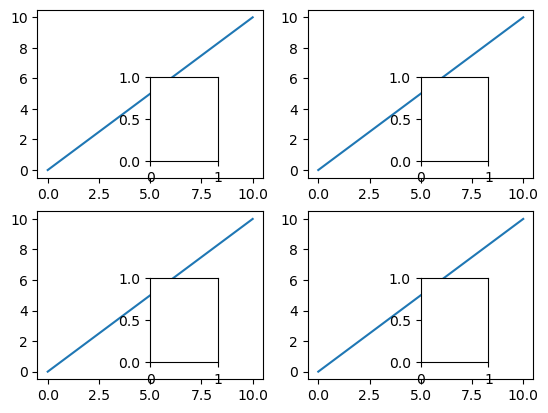

In [74]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,2)

for ax in axes.flat:
    ax.plot(np.arange(11),np.arange(11))

    ins = ax.inset_axes([0.5,0.1,0.3,0.5])

plt.show()